# I. Import libraries

In [1]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import tqdm

In [2]:
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image
import requests

# II. Load dataset

In [3]:
# Define the file path
file_path = '/kaggle/input/flickr30k/captions.txt'

# Read the first 2 rows of the file
with open(file_path, 'r') as file:
    for i, line in enumerate(file):
        print(f"Line {i + 1}: {line.strip()}")
        if i == 1:  # Stop after 2 lines
            break

Line 1: image_name|caption_number|caption_text
Line 2: 1000092795.jpg|0|Two young guys with shaggy hair look at their hands while hanging out in the yard .


In [4]:
import pandas as pd

# Define the file path
file_path = '/kaggle/input/flickr30k/captions.txt'

# Read the file, using the first line as header
df = pd.read_csv(file_path, delimiter='|')

In [5]:
df.head()

,image_name,caption_number,caption_text
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158915 non-null  object
 1   caption_number  158915 non-null  int64 
 2   caption_text    158915 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [7]:
# Define the image folder path
image_folder = '/kaggle/input/flickr30k/images/flickr30k_images'

# Add a new column with the full image path
df['path'] = image_folder + '/' + df['image_name']

In [8]:
df.head()

,image_name,caption_number,caption_text,path
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,/kaggle/input/flickr30k/images/flickr30k_image...
1,1000092795.jpg,1,"Two young , White males are outside near many ...",/kaggle/input/flickr30k/images/flickr30k_image...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,/kaggle/input/flickr30k/images/flickr30k_image...
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,/kaggle/input/flickr30k/images/flickr30k_image...
4,1000092795.jpg,4,Two friends enjoy time spent together .,/kaggle/input/flickr30k/images/flickr30k_image...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158915 non-null  object
 1   caption_number  158915 non-null  int64 
 2   caption_text    158915 non-null  object
 3   path            158915 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.8+ MB


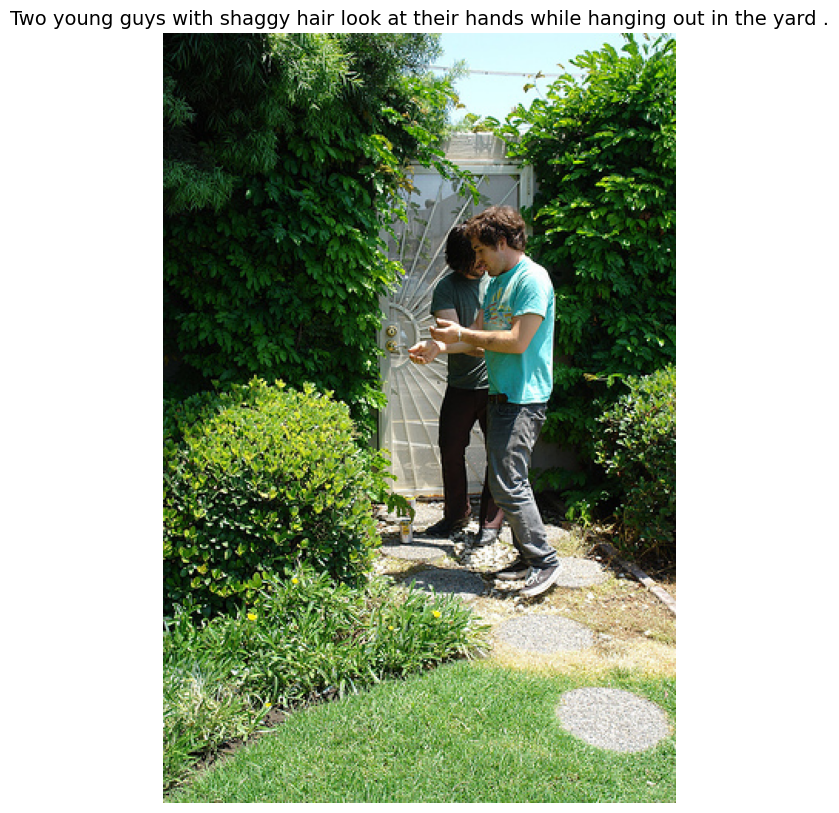

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

# Get the first image path and its caption
first_image_path = df['path'].iloc[0]
first_caption = df['caption_text'].iloc[0]

# Load the image
image = Image.open(first_image_path)

# Display the image along with the caption
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.title(first_caption, fontsize=14)
plt.show()

In [11]:
df[df['caption_text'].isna()]

,image_name,caption_number,caption_text,path


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158915 non-null  object
 1   caption_number  158915 non-null  int64 
 2   caption_text    158915 non-null  object
 3   path            158915 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.8+ MB


In [13]:
df.head()

,image_name,caption_number,caption_text,path
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,/kaggle/input/flickr30k/images/flickr30k_image...
1,1000092795.jpg,1,"Two young , White males are outside near many ...",/kaggle/input/flickr30k/images/flickr30k_image...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,/kaggle/input/flickr30k/images/flickr30k_image...
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,/kaggle/input/flickr30k/images/flickr30k_image...
4,1000092795.jpg,4,Two friends enjoy time spent together .,/kaggle/input/flickr30k/images/flickr30k_image...


# III. Data splitting

In [14]:
from sklearn.model_selection import train_test_split

# Step 1: Get unique image names
image_names = df['image_name'].unique()

# Step 2: Split image names into training and temporary (validation + test) sets
train_image_names, temp_image_names = train_test_split(image_names, test_size=0.2, random_state=42)

# Step 3: Split the temporary image names into validation and test sets
val_image_names, test_image_names = train_test_split(temp_image_names, test_size=0.5, random_state=42)

# Step 4: Filter the original DataFrame based on the image names in each split
train_df = df[df['image_name'].isin(train_image_names)]
val_df = df[df['image_name'].isin(val_image_names)]
test_df = df[df['image_name'].isin(test_image_names)]

In [15]:
print("Length of traning set",len(train_df))
print("Length of validation set",len(val_df))
print("Length of testing set",len(test_df))

Length of traning set 127130
Length of validation set 15890
Length of testing set 15895


In [16]:
# Define a function to filter images based on DataFrame
def filter_images(df):
    filtered_images = [(row['path'], row['caption_text']) for index, row in df.iterrows()]
    return filtered_images

# Filter images for training and testing sets
train_images = filter_images(train_df)
test_images = filter_images(test_df)
val_images = filter_images(val_df)

# IV. Prepare data for training

In [17]:
from transformers import BertTokenizer
from torch.utils.data import Dataset
import torch
from PIL import Image

class CaptionDataset(Dataset):
    def __init__(self, data, transform=None, tokenizer=None, max_length=50):
        """
        Args:
            data (list of tuples): A list where each tuple contains (image_path, caption).
            transform (callable, optional): Optional transform to be applied on a sample (image).
            tokenizer (BertTokenizer): Pretrained tokenizer for BERT (or any transformer model).
            max_length (int, optional): Maximum length of encoded captions (for padding/truncation).
        """
        self.data = data
        self.transform = transform
        self.max_length = max_length

        # Initialize the BERT tokenizer
        self.tokenizer = tokenizer if tokenizer else BertTokenizer.from_pretrained('bert-base-uncased')

    def encode_caption(self, caption):
        """
        Converts a caption (string) into a list of token IDs using the BERT tokenizer.
        """
        # Tokenize and encode the caption with special tokens
        encoding = self.tokenizer.encode_plus(
            caption,
            add_special_tokens=True,  # Add [CLS] and [SEP]
            padding='max_length',     # Pad to max_length
            truncation=True,          # Truncate to max_length if needed
            max_length=self.max_length,  # Max length of caption
            return_tensors='pt',      # Return PyTorch tensors
        )

        # Return the encoded caption as a tensor (token IDs)
        return encoding['input_ids'].squeeze(0)  # Remove batch dimension

    def decode_caption(self, encoded_caption):
        """
        Decodes the tokenized caption back to a string using the BERT tokenizer.
        """
        decoded_caption = self.tokenizer.decode(encoded_caption, skip_special_tokens=True)
        return decoded_caption
    
    def convert_to_tokens(self, encoded_caption):
        tokens_converted = self.tokenizer.convert_ids_to_tokens(encoded_caption)
        return tokens_converted

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            tuple: (image, encoded_caption)
                - image: The transformed image tensor.
                - encoded_caption: The encoded caption as a tensor of token IDs.
        """
        image_path, caption = self.data[idx]
        
        # Load the image
        image = Image.open(image_path).convert('RGB')
        
        # Apply the image transformation (if any)
        if self.transform:
            image = self.transform(image)
        
        # Encode the caption using the BERT tokenizer
        encoded_caption = self.encode_caption(caption)
        
        return image, encoded_caption


In [18]:
from torchvision import transforms

# Training set transformations: Include augmentations like random horizontal flip, rotation, etc.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),               # Resize to a fixed size
    transforms.RandomHorizontalFlip(),           # Randomly flip the image
    transforms.RandomRotation(20),              # Random rotation
    transforms.ToTensor(),                      # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

# Validation and test set transformations: Only resizing and normalization
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),               # Resize to a fixed size
    transforms.ToTensor(),                       # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

In [19]:
# Create the CaptionDataset instance
train_dataset = CaptionDataset(data=train_images, transform=train_transform)
val_dataset = CaptionDataset(data=val_images, transform=val_test_transform)
test_dataset = CaptionDataset(data=test_images, transform=val_test_transform)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

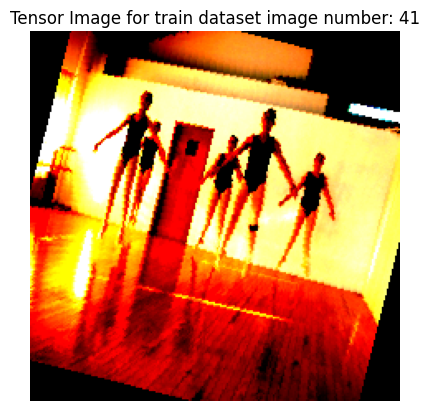

Tokenized Captions:
five ballet dancers caught mid jump in a dancing studio with sunlight coming through a window.
Encoded Tensor Captions:
tensor([  101,  2274,  7250, 10487,  3236,  3054,  5376,  1999,  1037,  5613,
         2996,  2007,  9325,  2746,  2083,  1037,  3332,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Tokenized Captions IDs:
['[CLS]', 'five', 'ballet', 'dancers', 'caught', 'mid', 'jump', 'in', 'a', 'dancing', 'studio', 'with', 'sunlight', 'coming', 'through', 'a', 'window', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [20]:
image_number = 40
#Random image
img_tensor, cap_tensor =  train_dataset[image_number]
# Convert the PyTorch tensor to a numpy array for displaying
image_np = img_tensor.permute(1, 2, 0).numpy()

# Display the image with title Tensor Image
plt.title(f"Tensor Image for train dataset image number: {image_number+1}")
plt.imshow(image_np)
plt.axis('off')
plt.show()

print("Tokenized Captions:")
print(train_dataset.decode_caption(cap_tensor))

# Display the captions
print("Encoded Tensor Captions:")
print(cap_tensor)

print("Tokenized Captions IDs:")
print(train_dataset.convert_to_tokens(cap_tensor))

In [21]:
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
from torch.utils.data import DataLoader

def collate_fn(batch):
    """
    Custom collate function to handle padding and batching for image-caption pairs.
    
    Args:
        batch (list of tuples): Each tuple contains (image, caption) where
                                 image is a tensor and caption is a string.
    
    Returns:
        dict: Contains 'images' (batch of images) and 'captions' (padded encoded captions).
    """
    # Initialize lists for images and captions
    images = []
    captions = []
    
    # Load BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    for image, caption in batch:
        # Append the image tensor (already preprocessed and transformed)
        images.append(image)
        
        # Check if the caption is already tokenized (if it's a list of integers, skip tokenization)
        if isinstance(caption, str):  # Only tokenize if it's raw text
            encoding = tokenizer.encode_plus(
                caption,               # The raw caption text
                add_special_tokens=True,  # Add [CLS] and [SEP]
                padding='max_length',  # Pad to the max length
                truncation=True,       # Truncate if longer than max length
                max_length=50,         # Maximum length of caption (adjust as needed)
                return_tensors='pt',   # Return tensors
            )
            # Get the tokenized caption
            captions.append(encoding['input_ids'].squeeze(0))  # Remove the batch dimension
        else:  # If it's already tokenized (list of integers), just append
#             captions.append(torch.tensor(caption))  # Convert list of integers to tensor
            captions.append(caption.clone().detach())


    # Stack all the images into a batch
    images = torch.stack(images, dim=0)  # Shape: [batch_size, 3, H, W]
    
    # Pad the captions to make sure all captions in the batch have the same length
    captions = pad_sequence(captions, batch_first=True, padding_value=tokenizer.pad_token_id)
    
    return {
        'images': images,        # Batch of images
        'captions': captions     # Padded batch of tokenized captions
    }

In [22]:
batch_size = 32
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=2)

In [23]:
# Example of iterating through the DataLoader
for batch in train_loader:
    images = batch['images']
    captions = batch['captions']
#     print(batch)
    print("Batch of images:", images.shape)  # Should be [batch_size, 3, 224, 224]
    print("Batch of captions:", captions.shape)  # Should be [batch_size, max_caption_length]
    print("Captions:", captions)
    break  # For illustration, we break after the first batch

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch of images: torch.Size([32, 3, 224, 224])
Batch of captions: torch.Size([32, 50])
Captions: tensor([[ 101, 1037, 2879,  ...,    0,    0,    0],
        [ 101, 1016, 2402,  ...,    0,    0,    0],
        [ 101, 2006, 1037,  ...,    0,    0,    0],
        ...,
        [ 101, 1037, 7133,  ...,    0,    0,    0],
        [ 101, 1037, 2402,  ...,    0,    0,    0],
        [ 101, 1037, 2402,  ...,    0,    0,    0]])


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [24]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

def visual_images(train_loader,i=4):
    i=4
    for batch in train_loader:
        images = batch['images']
        captions = batch['captions']

        # Get the first image and its caption
        img_tensor = images[i]
        cap_tensor = captions[i]

        # Convert the PyTorch tensor to a numpy array for displaying
        image_np = img_tensor.permute(1, 2, 0).numpy()

        # Display the image with title Tensor Image
        plt.title(f"Tensor Image for train dataset image number: {image_number+1}")
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()

        print("Tokenized Captions:")
        print(train_dataset.decode_caption(cap_tensor))
        # Display the captions
        print("Encoded Tensor Captions:")
        print(cap_tensor)

        break

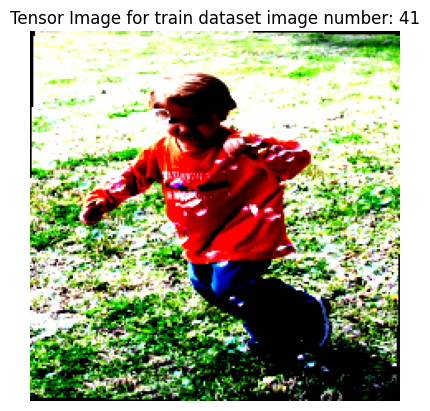

Tokenized Captions:
a child blows bubbles outside.
Encoded Tensor Captions:
tensor([  101,  1037,  2775, 13783, 17255,  2648,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [25]:
visual_images(train_loader,i=30)

# V. Encoder and decoder architecture

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# Encoder class: CNN feature extractor (e.g., ResNet)
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        # Using ResNet as the backbone for feature extraction
        resnet = models.resnet50(pretrained=True)  # Use ResNet-50
        
        for param in resnet.parameters():
            param.requires_grad_(False)
            
        modules = list(resnet.children())[:-1]  # Remove the fully connected layers
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)  # Output embedding size

    def forward(self, images):
        # Pass the image through ResNet
        with torch.no_grad():  # We don't need gradients for the ResNet part
            features = self.resnet(images)
        # Flatten the features and pass through the fully connected layer
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return features

In [27]:
import torch

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)  # Word embeddings
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, vocab_size)  # Output to vocab_size
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8)

        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        h_0 = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        c_0 = torch.zeros_like(h_0)  # Initialize cell states to zeros
        lstm_out, (h_n, c_n) = self.lstm(embeddings, (h_0, c_0))
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        output = self.fc_out(attn_output)
        return output

    def greedy_decode(self, features, max_length=20, start_token=0, end_token=1):
        """
        Args:
            features (tensor): Extracted image features (batch_size, embed_size)
            max_length (int): Maximum length of the caption to generate
            start_token (int): Index of the <start> token
            end_token (int): Index of the <end> token
        """
        # Initialize the input to be the start token
        input_caption = torch.tensor([[start_token]]).to(features.device)  # (1, 1) for batch_size = 1
        
        # List to store the generated caption (tokens)
        generated_caption = []

        # Set the initial hidden and cell states from the image features
        h_0 = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        c_0 = torch.zeros_like(h_0)

        for _ in range(max_length):
            # Pass the input_caption through the decoder
            output = self(input_caption, input_caption)  # We pass the input caption for the decoder
            
            # Get the output logits for the last word (output is (batch_size, seq_len, vocab_size))
            output = output[:, -1, :]  # Select the last time step (the last word output)
            
            # Get the word with the maximum probability (greedy approach)
            _, predicted_token = torch.max(output, dim=1)
            
            # Append the predicted word to the generated caption
            generated_caption.append(predicted_token.item())
            
            # If the predicted word is the end token, break the loop
            if predicted_token.item() == end_token:
                break
            
            # Prepare the next input as the predicted token
            input_caption = predicted_token.unsqueeze(0).unsqueeze(0)  # (1, 1)

        return generated_caption

In [28]:
# Define a simple Image Captioning Model combining Encoder and Decoder
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [29]:
# Model hyperparameters
embed_size = 512
hidden_size = 512
vocab_size=len(train_dataset.tokenizer.get_vocab())

In [30]:
model = ImageCaptioningModel(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s] 


In [31]:
model

ImageCaptioningModel(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

# VI. Training

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [33]:
model.to(device)

ImageCaptioningModel(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

In [34]:
# Initialize the model, loss function, and optimizer
import torch.optim as optim

factor = 0.1
threshold = 0.01
min_lr = 1e-6
patience = 2
learning_rate = 0.001 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=factor, threshold=threshold, min_lr=min_lr)

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm  # Import tqdm for the progress bar

# Initialize the TensorBoard writer
writer = SummaryWriter("runs/flickr")
step = 0
save_model = True

best_val_loss = float('inf')
counter = 0  # Counter for patience

num_epochs = 30

# Lists to store losses and perplexities
train_losses = []
train_perplexities = []
val_losses = []
val_perplexities = []


# Ensure model, criterion, optimizer are initialized before starting the loop

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_perplexity = 0.0

    # Training loop with tqdm progress bar
    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", unit="batch")):
        # Extract images and captions from the batch
        images_tensor = batch['images']
        captions_tensor = batch['captions']

        # Move both images and captions to the device (GPU or CPU)
        images_tensor, captions_tensor = images_tensor.to(device), captions_tensor.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass (Assuming your model takes both images and captions)
        outputs = model(images_tensor, captions_tensor)

        # Compute the loss (you may need to adjust the loss calculation based on your task)
        loss = criterion(outputs.view(-1, vocab_size), captions_tensor.view(-1))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute perplexity
        perplexity = torch.exp(loss)
        running_perplexity += perplexity.item()

    # Average loss and perplexity for the epoch
    avg_loss = running_loss / len(train_loader)
    avg_perplexity = running_perplexity / len(train_loader)

    # Log to TensorBoard
    writer.add_scalar('Loss/train', avg_loss, epoch)
    writer.add_scalar('Perplexity/train', avg_perplexity, epoch)

    # Save model if it's the best so far
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        counter = 0  # Reset the patience counter
        if save_model:
            torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1

    # Add to lists for later analysis
    train_losses.append(avg_loss)
    train_perplexities.append(avg_perplexity)

    # Validation loop with tqdm progress bar
    model.eval()
    val_loss = 0.0
    val_perplexity = 0.0

    for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Validation", unit="batch"):
        # Extract images and captions from the validation batch
        images_tensor = batch['images']
        captions_tensor = batch['captions']

        # Move both images and captions to the device (GPU or CPU)
        images_tensor, captions_tensor = images_tensor.to(device), captions_tensor.to(device)

        # Forward pass
        outputs = model(images_tensor, captions_tensor)

        # Compute validation loss
        loss = criterion(outputs.view(-1, vocab_size), captions_tensor.view(-1))

        # Compute perplexity for validation
        perplexity = torch.exp(loss)

        val_loss += loss.item()
        val_perplexity += perplexity.item()

    # Average validation loss and perplexity for the epoch
    avg_val_loss = val_loss / len(val_loader)
    avg_val_perplexity = val_perplexity / len(val_loader)

    # Log to TensorBoard for validation
    writer.add_scalar('Loss/val', avg_val_loss, epoch)
    writer.add_scalar('Perplexity/val', avg_val_perplexity, epoch)

    # Print detailed epoch summary
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}, Training Perplexity: {avg_perplexity:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Perplexity: {avg_val_perplexity:.4f}, "
          f"Learning Rate: {current_lr:.6f}")

    # Step the scheduler based on the validation loss
    scheduler.step(avg_val_loss)

    # Early stopping check based on validation loss
    if counter >= patience:
        print(f"Early stopping after {epoch + 1} epochs")
        break

# After training, you can save the model and plot graphs using the data in `train_losses`, `train_perplexities`, etc.
writer.close()

Epoch 1/30 Validation: 100%|██████████| 497/497 [01:34<00:00,  5.25batch/s]


Epoch [1/30], Training Loss: 0.2454, Training Perplexity: 11.6710, Validation Loss: 0.1352, Validation Perplexity: 1.1460, Learning Rate: 0.001000


Epoch 2/30 Validation: 100%|██████████| 497/497 [01:33<00:00,  5.29batch/s]


Epoch [2/30], Training Loss: 0.1281, Training Perplexity: 1.4364, Validation Loss: 0.1048, Validation Perplexity: 1.1114, Learning Rate: 0.001000


Epoch 3/30 Validation: 100%|██████████| 497/497 [01:33<00:00,  5.33batch/s]


Epoch [3/30], Training Loss: 0.1273, Training Perplexity: 2.8987, Validation Loss: 0.0897, Validation Perplexity: 1.0946, Learning Rate: 0.001000


Epoch 4/30 Validation: 100%|██████████| 497/497 [01:33<00:00,  5.33batch/s]


Epoch [4/30], Training Loss: 0.0846, Training Perplexity: 1.0888, Validation Loss: 0.0872, Validation Perplexity: 1.0935, Learning Rate: 0.001000


Epoch 5/30 Validation: 100%|██████████| 497/497 [01:33<00:00,  5.34batch/s]


Epoch [5/30], Training Loss: 0.0837, Training Perplexity: 1.0994, Validation Loss: 0.0855, Validation Perplexity: 1.2493, Learning Rate: 0.001000


Epoch 6/30 Validation: 100%|██████████| 497/497 [01:32<00:00,  5.36batch/s]


Epoch [6/30], Training Loss: 0.0872, Training Perplexity: 62.8370, Validation Loss: 0.0706, Validation Perplexity: 1.0737, Learning Rate: 0.001000


Epoch 7/30 Validation: 100%|██████████| 497/497 [01:33<00:00,  5.33batch/s]


Epoch [7/30], Training Loss: 0.0644, Training Perplexity: 1.0669, Validation Loss: 0.0681, Validation Perplexity: 1.0713, Learning Rate: 0.001000


Epoch 8/30 Validation: 100%|██████████| 497/497 [01:35<00:00,  5.18batch/s]


Epoch [8/30], Training Loss: 0.0661, Training Perplexity: 1.0690, Validation Loss: 0.0711, Validation Perplexity: 1.0753, Learning Rate: 0.001000


Epoch 9/30 Validation: 100%|██████████| 497/497 [01:36<00:00,  5.17batch/s]

Epoch [9/30], Training Loss: 0.0911, Training Perplexity: 320438.9625, Validation Loss: 0.0736, Validation Perplexity: 1.0779, Learning Rate: 0.001000
Early stopping after 9 epochs


# VII. Evaluation

In [36]:
# Load the model weights from the saved best model
model.load_state_dict(torch.load('/kaggle/input/best-model/best_model.pth'))

/tmp/ipykernel_30/1079790483.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/best-model/best_model.pth'))


<All keys matched successfully>

In [37]:
# Move the model to the appropriate device (GPU or CPU)
model.to(device)

ImageCaptioningModel(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

In [38]:
model.eval()

ImageCaptioningModel(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

In [41]:
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')

In [42]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

# Initialize lists to store images, predicted captions, ground truth captions, and BLEU scores
all_images = []
all_predicted_captions = []
all_ground_truth_captions = []
all_bleu_scores = []

# Define a function to calculate BLEU scores
def calculate_bleu(pred, refs):
    bleu_scores = []
    smoothing = SmoothingFunction()

    # Tokenization
    pred_tokens = pred.split()
    refs_tokens = [ref.replace('<start>', '').replace('<end>', '').split() for ref in refs]

    # Calculate BLEU-1, BLEU-2, BLEU-3, BLEU-4
    bleu1 = sentence_bleu(refs_tokens, pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing.method1)
    bleu2 = sentence_bleu(refs_tokens, pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing.method1)
    bleu3 = sentence_bleu(refs_tokens, pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing.method1)
    bleu4 = sentence_bleu(refs_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing.method1)

    bleu_scores.extend([bleu1, bleu2, bleu3, bleu4])

    return bleu_scores

In [43]:
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", unit="batch"):
        images_tensor = batch['images']
        captions_tensor = batch['captions']
        
        images_tensor, captions_tensor = images_tensor.to(device), captions_tensor.to(device)
        
        # Forward pass: Get the predictions from the model
        outputs = model(images_tensor, captions_tensor)
        
        for i in range(outputs.size(0)):  # Iterate over the batch
            # Get predicted caption
            predicted_caption = torch.argmax(outputs[i], dim=1)
            predicted_caption = predicted_caption.squeeze(0).cpu().numpy()
            decoded_caption = tokenizer.decode(predicted_caption, skip_special_tokens=True)
            
            # Get ground truth caption
            true_caption = captions_tensor[i].cpu().numpy()
            decoded_true_caption = tokenizer.decode(true_caption, skip_special_tokens=True)
            
            # Append results to the lists
            all_predicted_captions.append(decoded_caption)
            all_ground_truth_captions.append(decoded_true_caption)
            
            # Convert image from CHW to HWC and append it
            all_images.append(images_tensor[i].cpu().numpy().transpose(1, 2, 0))
            
            # Calculate BLEU scores for the current pair
            bleu_scores = calculate_bleu(decoded_caption, [decoded_true_caption])
            all_bleu_scores.append(bleu_scores)

Testing: 100%|██████████| 497/497 [01:46<00:00,  4.67batch/s]


# VIII. Calcualte BLEU scores

In [44]:
# Calculate the average BLEU scores
average_bleu_scores = [0, 0, 0, 0]  # BLEU-1, BLEU-2, BLEU-3, BLEU-4
for bleu_scores in all_bleu_scores:
    for i in range(4):
        average_bleu_scores[i] += bleu_scores[i]

# Compute the average BLEU scores
average_bleu_scores = [score / len(all_bleu_scores) for score in average_bleu_scores]

# Print the average BLEU scores
print("Average BLEU Scores:")
print("Average BLEU-1:", average_bleu_scores[0])
print("Average BLEU-2:", average_bleu_scores[1])
print("Average BLEU-3:", average_bleu_scores[2])
print("Average BLEU-4:", average_bleu_scores[3])


Average BLEU Scores:
Average BLEU-1: 0.9454365431963776
Average BLEU-2: 0.9248614168399125
Average BLEU-3: 0.9047715924757447
Average BLEU-4: 0.8822021975605375


# IX. Prediction on test set

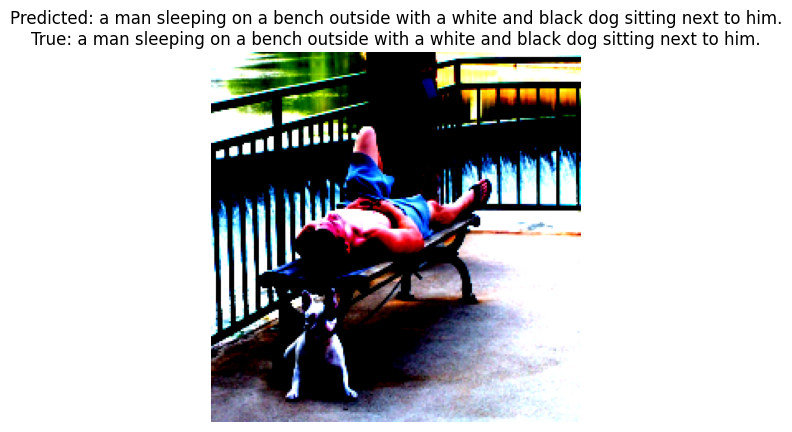

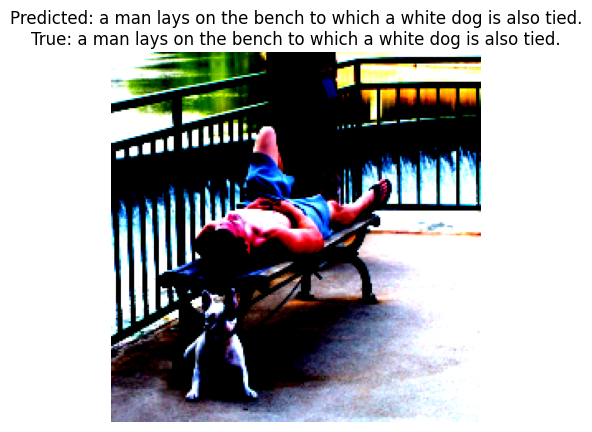

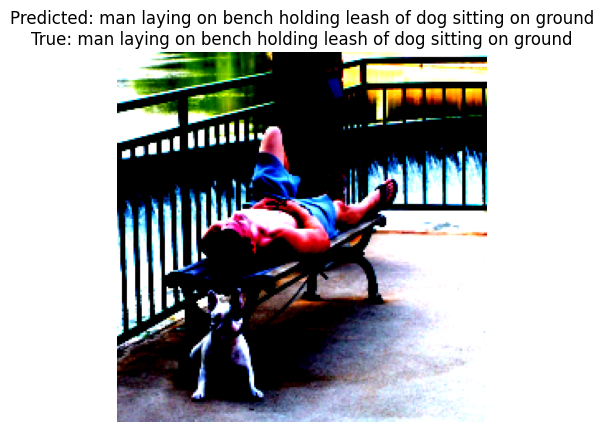

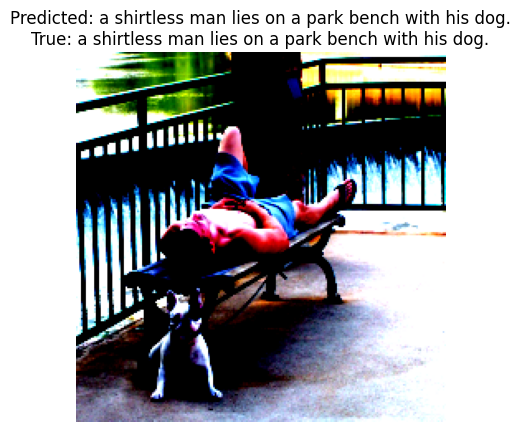

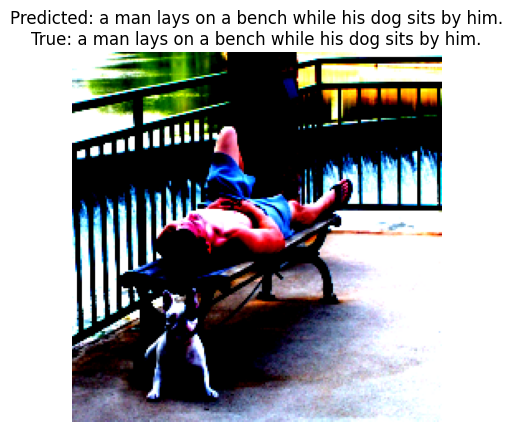

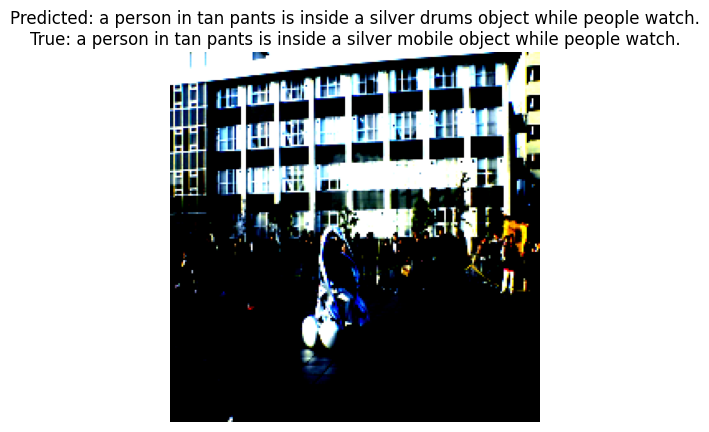

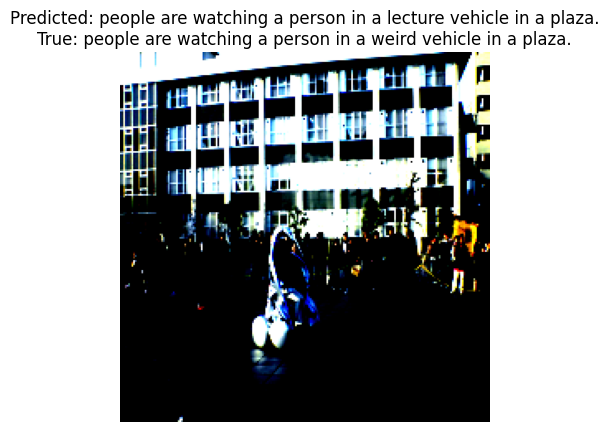

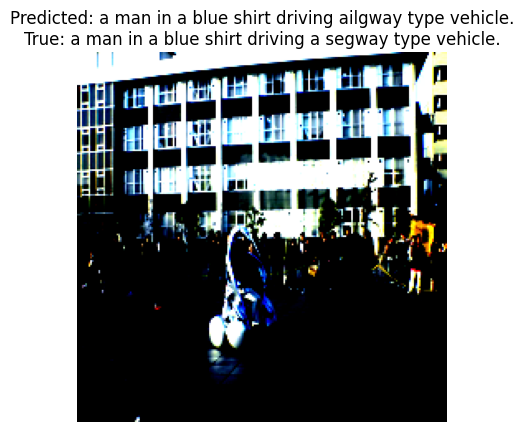

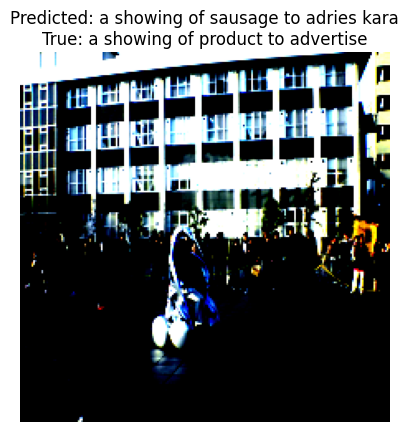

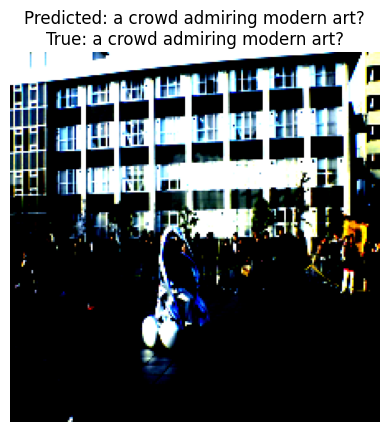

In [45]:
selected_images=all_images[0:10]
selected_prediction=all_predicted_captions[0:10]
selected_ground_truth_caption=all_ground_truth_captions[0:10]
# Now visualize the images with captions
for i in range(len(selected_images)):  # Loop over all_images, not the integer 10
    plt.imshow(selected_images[i])
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted: {selected_prediction[i]}\nTrue: {selected_ground_truth_caption[i]}")
    plt.show()

# X. Zip our output

In [89]:
import shutil

# Path to the folder you want to zip
folder_path = '/kaggle/working/runs'

# Path to save the zip file
zip_file_path = '/kaggle/working/runs.zip'

# Create a zip file
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

print(f'Folder zipped successfully to {zip_file_path}')

Folder zipped successfully to /kaggle/working/runs.zip
